Data : https://www.kaggle.com/slothkong/10-monkey-species

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
from pathlib import Path
import keras
import tensorflow as tf 

In [9]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [10]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

 pygmy_marmoset                


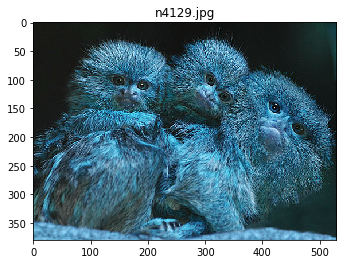

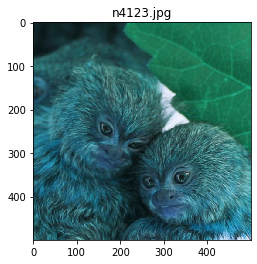

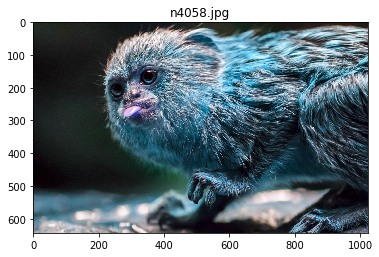

In [11]:
def image_show(nb_image, label):
    for i in range(nb_image):
        imgdir = Path('training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('training/'+ label +'/'+ imgfile)
        #print(img.shape)
        #print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()
    
print(labels[4])
image_show(3,'n4')

In [12]:
train_dir = Path('training/')
test_dir = Path('validation/')

from keras.preprocessing.image import ImageDataGenerator

height=150 # images ont des tailles différentes donc on prend 150x150 pixels
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255, # Multiply the data by the rescale (after applying all other transformations)
        rotation_range=40, # Degree range for random rotations
        width_shift_range=0.2, # Fraction of total width
        height_shift_range=0.2, # Fraction of total height
        shear_range=0.2, # Shear Intensity
        zoom_range=0.2, # Range for random zoom
        horizontal_flip=True, # Randomly flip inputs horizontally
        fill_mode='nearest', # Points outside the boundaries of the input are filled according to 'aaaaaaaa|abcd|dddddddd'
        validation_split=0.05) # test

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width), # Size to resize images
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    subset='training')

test_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    subset='validation')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(height,width), 
                                                   batch_size=batch_size,
                                                   seed=seed,
                                                   shuffle=False,
                                                   class_mode='categorical')

# The directory must be set to the path where your ‘n’ classes of folders are present.
#The target_size is the size of your input images, every image will be resized to this size.
#color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
#batch_size: No. of images to be yielded from the generator per batch.
#class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.
#shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
#seed: Random seed for applying random image augmentation and shuffling the order of the image.

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1047 images belonging to 11 classes.
Found 51 images belonging to 11 classes.
Found 272 images belonging to 11 classes.


In [13]:
model = keras.models.Sequential([
                     keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
                     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
                     keras.layers.Conv2D(32, (3, 3), activation='relu'),
                     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
                     keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
                     keras.layers.Conv2D(64, (3, 3), activation='relu'),
                     keras.layers.MaxPooling2D(pool_size=(2, 2)),
                     keras.layers.Dropout(0.25),
    
                     keras.layers.Flatten(),
                     keras.layers.Dense(512, activation='relu'),
                     keras.layers.Dropout(0.5),
                     keras.layers.Dense(num_classes+1, activation='softmax')       
])

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)       

In [15]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc',
                                              patience=15, 
                                              restore_best_weights=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=200,
                              validation_data=validation_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=[early_stopping])#0.7452

Epoch 1/200
16/16 [==============================] - 80s 5s/step - loss: 2.4532 - acc: 0.1068 - val_loss: 2.4533 - val_acc: 0.1211
Epoch 2/200
16/16 [==============================] - 83s 5s/step - loss: 2.2895 - acc: 0.1394 - val_loss: 2.2641 - val_acc: 0.2740
Epoch 3/200
16/16 [==============================] - 116s 7s/step - loss: 2.0659 - acc: 0.2744 - val_loss: 1.5139 - val_acc: 0.3894
Epoch 4/200
16/16 [==============================] - 112s 7s/step - loss: 1.9525 - acc: 0.3079 - val_loss: 1.8671 - val_acc: 0.3365
Epoch 5/200
16/16 [==============================] - 120s 7s/step - loss: 1.9153 - acc: 0.3066 - val_loss: 1.3043 - val_acc: 0.3894
Epoch 6/200
16/16 [==============================] - 126s 8s/step - loss: 1.7683 - acc: 0.3620 - val_loss: 1.8113 - val_acc: 0.4727
Epoch 7/200
16/16 [==============================] - 148s 9s/step - loss: 1.7399 - acc: 0.3770 - val_loss: 1.6392 - val_acc: 0.4663
Epoch 8/200
16/16 [==============================] - 113s 7s/step - loss: 1.62

In [16]:
model.evaluate_generator(test_generator, test_generator.samples) # [loss, acc]

[0.8788402676582336, 0.6312956809997559]

Test

In [173]:
test_dir = Path('test/')

from keras.preprocessing.image import ImageDataGenerator

height=150 # images ont des tailles différentes donc on prend 150x150 pixels
width=150
channels=3
seed=1337
batch_size = 64

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_image_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(height,width), 
                                                   batch_size=batch_size,
                                                   seed=seed,
                                                   shuffle=False,
                                                   class_mode='categorical')

test_num = test_image_generator.samples 

#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("monkey_labels.txt", names=cols, skiprows=1)
labels

Found 3 images belonging to 11 classes.


,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


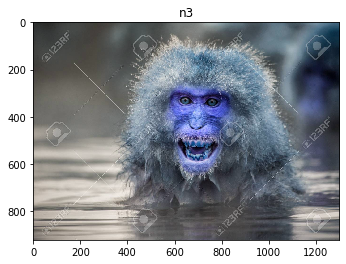

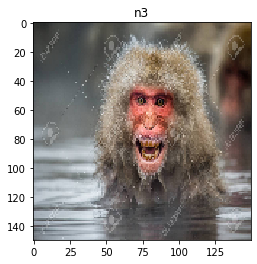

Classe : 4
Probabilité : 0.9995982050895691


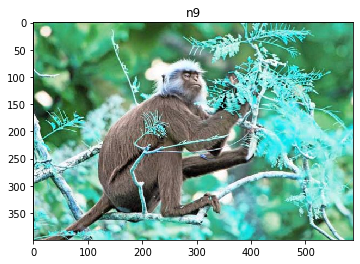

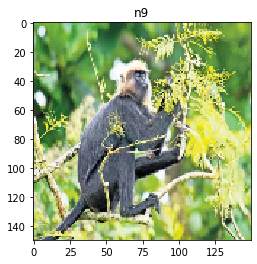

Classe : 10
Probabilité : 0.9489750266075134


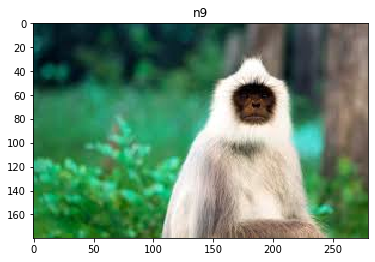

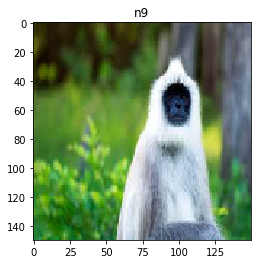

Classe : 6
Probabilité : 0.9092833399772644


In [174]:
imgdir = Path('test/')
liste_dossiers = os.listdir(imgdir)[1:]
compteur = 0
compteur_seconde_image = 1
for dossier in liste_dossiers:
    image = os.listdir(Path('test/' + dossier))
    for image in os.listdir(Path('test/' + dossier)):  
        if image == '.ipynb_checkpoints':
            continue
        img = cv2.imread('test/'+ dossier +'/'+ image)
        plt.figure(compteur)
        plt.imshow(img)
        plt.title(dossier)
        
        plt.show()
        
        plt.figure(compteur_seconde_image)
        plt.imshow(test_image_generator[0][0][compteur])
        plt.title(dossier)
        plt.show()
        
        compteur_seconde_image += 1
        
        classe = model.predict_classes(test_image_generator[0][0], test_image_generator.samples)[compteur]
        print(f'Classe : {classe}')
        print(f'Probabilité : {model.predict(test_image_generator[0][0], test_image_generator.samples)[compteur][classe]}')
        #print(f'Toutes les probabilité : {model.predict(test_image_generator[0][0], test_image_generator.samples)[compteur]}\n')
    
        compteur += 1 